In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
warnings.filterwarnings("ignore")

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False
database = pd.read_csv("./肺结节浸润性ITH.csv")#同一级文件夹 './file.csv'   ##子目录文件夹'./subfolder/file.csv'  ##上级文件夹'../otherfolder/file.csv'  
rand_seed = 123  #  数据划分的随机种子
ratio=0.3


y = database["Outcome"]#结局指标
X = database.drop(["Outcome"], axis= 1)#设置自变量
#数据集拆分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= ratio, random_state= rand_seed)

In [11]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
# 定义一级学习器
base_learners = [
    ("RF", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("XGB", XGBClassifier(n_estimators=100, random_state=42, verbosity=0)),
    ("LGBM", LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)),
    ("GBM", GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ("AdaBoost", AdaBoostClassifier(n_estimators=100, random_state=42)),
    ("CatBoost", CatBoostClassifier(n_estimators=100, random_state=42, verbose=0))  
]

# 定义二级学习器
# meta_model = LinearRegression()
meta_model = LogisticRegression()

# 创建Stacking回归器
# stacking_Classifier = StackingClassifier(estimators=base_learners, final_estimator=meta_model, cv=5)
stacking_Classifier = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())

# 训练模型
stacking_Classifier.fit(X_train, y_train)

StackingClassifier(estimators=[('RF', RandomForestClassifier(random_state=42)),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_t...
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('LGBM',
                                LGBMClassifier(random_state=42, verbose=-1)),
                               ('GBM',
                                GradientBoostingClassifier(random_state=42)),
                               ('AdaBoost',
                                AdaBoostClassifier(n_estimators=100,
                                                   random_state=42)),
                               ('CatBoost',
                                <catboost.core.CatBoostClassifier object at 0x000001CEE66CE650>)],
                   final_estimator=LogisticRegression())

## 保存模型

In [24]:
import joblib
joblib.dump(stacking_Classifier, "stacking_classifier_model.pkl")

['stacking_classifier_model.pkl']

## 第一层

In [13]:
import shap

# 创建一个字典保存每个模型的 SHAP DataFrame
shap_dfs = {}

# 遍历一级学习器
for name, model in stacking_Classifier.named_estimators_.items():
    try:
        if hasattr(model, "predict"):  # 确保模型支持预测
            # 判断是否为树模型
            if isinstance(model, (RandomForestClassifier, GradientBoostingClassifier, XGBClassifier, LGBMClassifier, CatBoostClassifier)):
                explainer = shap.TreeExplainer(model)
            else:
                # 使用 KernelExplainer 处理非树模型
                explainer = shap.KernelExplainer(model.predict, X_test)

            # 计算 SHAP 值
            shap_values = explainer.shap_values(X_test)

            # 转化为 DataFrame 保存
            shap_df = pd.DataFrame(shap_values, columns=X_test.columns)
            shap_dfs[name] = shap_df

    except Exception as e:
        print(f"Error computing SHAP for model {name}: {e}")

Using 158 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Error computing SHAP for model RF: Must pass 2-d input. shape=(158, 13, 2)


  0%|          | 0/158 [00:00<?, ?it/s]

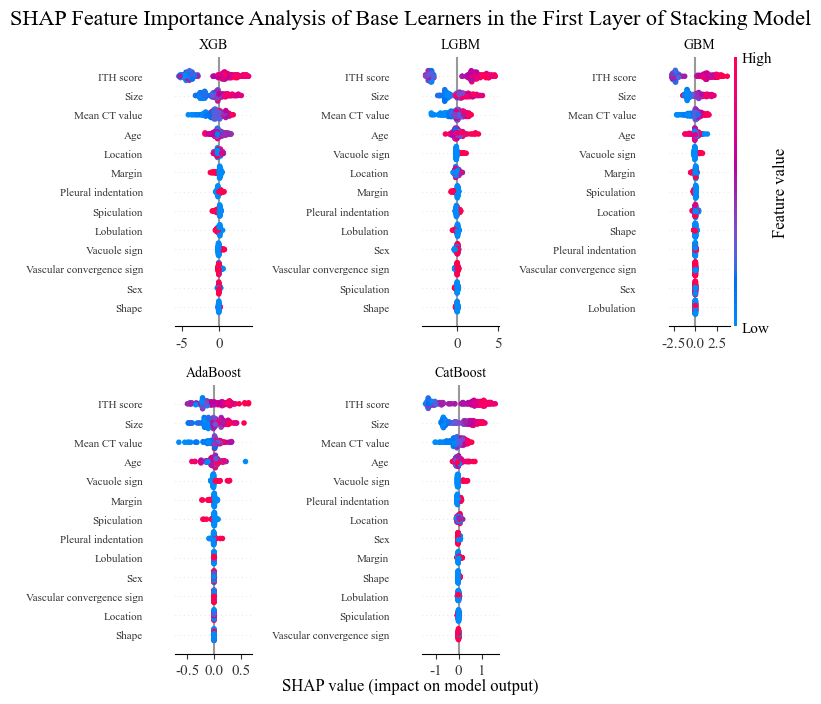

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  
axes = axes.flatten()  
# 遍历模型和轴，绘制summary plot
for i, (name, shap_df) in enumerate(shap_dfs.items()):
    try:
        if i >= len(axes):  
            break
        plt.sca(axes[i])  
        show_color_bar = (i % 3 == 2)  
        shap.summary_plot(
            shap_values=shap_df.to_numpy(),
            features=X_test,
            feature_names=X_test.columns,
            plot_type="dot",
            show=False,
            color_bar=show_color_bar  
        )
        plt.xlabel('')  
        axes[i].set_title(name, fontsize=10)  
        axes[i].tick_params(axis='y', labelsize=8)  
        if i % 3 != 0:  # 
            axes[i].set_ylabel("")
    except Exception as e:
        print(f"Error plotting SHAP summary for model {name}: {e}")
fig.text(0.5, 0.004, "SHAP value (impact on model output)", ha="center", fontsize=12)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout(rect=[0, 0, 1, 1])
fig.suptitle("SHAP Feature Importance Analysis of Base Learners in the First Layer of Stacking Model", fontsize=16, y=1.02)
plt.savefig("summary_plot.png", bbox_inches='tight', dpi=1200)
plt.show()

## 第二层

In [15]:
from sklearn.exceptions import NotFittedError

# 检查 final_estimator_ 是否已经被训练
try:
    meta_model = stacking_Classifier.final_estimator_  # 提取已训练好的二级学习器
except AttributeError:
    raise NotFittedError("The final estimator (meta_model) is not yet fitted. Ensure that the StackingRegressor is trained.")

# 获取一级学习器的预测值（作为二级学习器的输入特征）
meta_features = stacking_Classifier.transform(X_test)

# 使用 KernelExplainer 解释 LinearRegression
explainer_meta = shap.KernelExplainer(meta_model.predict, meta_features)

# 计算二级学习器的 SHAP 值
shap_values_meta = explainer_meta.shap_values(meta_features)

Using 158 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/158 [00:00<?, ?it/s]

In [16]:
shap_df = pd.DataFrame(shap_values_meta, columns=[name for name, _ in base_learners])
shap_df

,RF,XGB,LGBM,GBM,AdaBoost,CatBoost
0,-0.139451,-0.012658,0.041878,-0.023207,-0.000422,-0.144620
1,-0.107911,-0.012342,0.053797,-0.086814,-0.000738,-0.124473
2,-0.137025,-0.004114,0.017194,-0.011814,-0.003165,-0.139557
3,-0.137553,-0.003692,0.016350,-0.011709,-0.003270,-0.138608
4,0.375211,0.014135,-0.030380,0.022785,0.001266,0.338502
...,...,...,...,...,...,...
153,-0.111920,-0.012447,0.024051,-0.025633,-0.000844,-0.151688
154,-0.134177,-0.004219,0.020042,-0.014557,-0.003059,-0.142511
155,-0.135865,-0.004430,0.018987,-0.013397,-0.003586,-0.140190
156,-0.120359,-0.009599,0.024789,-0.043671,-0.001266,-0.128376


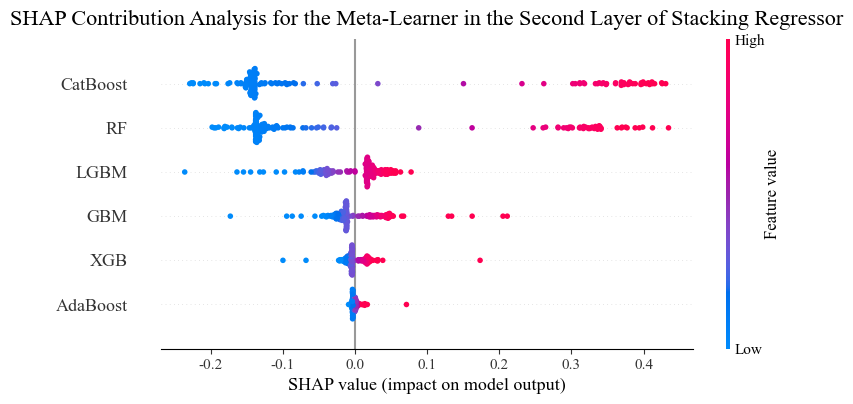

In [17]:
plt.figure()
shap.summary_plot(np.array(shap_df), shap_df, feature_names=shap_df.columns, plot_type="dot", show=False)
plt.title("SHAP Contribution Analysis for the Meta-Learner in the Second Layer of Stacking Regressor", fontsize=16, y=1.02)
plt.savefig("SHAP Contribution Analysis for the Meta-Learner in the Second Layer of Stacking Regressor.png", bbox_inches='tight', dpi=1200)
plt.show()

## 整体

In [18]:
# 使用 SHAP 的 KernelExplainer 对 Stacking 模型整体进行解释（代理模型方法）  # 这里只计算了100个样本节省时间
stacking_explainer = shap.KernelExplainer(stacking_Classifier.predict, X_test.iloc[0:100, :])
# 计算 SHAP 值（解释 Stacking 模型对输入特征的贡献）
stacking_shap_values = stacking_explainer.shap_values(X_test.iloc[0:100, :])
stacking_shap_df = pd.DataFrame(stacking_shap_values, columns=X_test.columns)
stacking_shap_df

  0%|          | 0/100 [00:00<?, ?it/s]

,Location,Margin,Shape,Lobulation,Spiculation,Vascular convergence sign,Vacuole sign,Pleural indentation,Sex,Age,Size,Mean CT value,ITH score
0,0.014727,0.013325,0.014981,-0.010337,-0.016694,-0.010321,-0.017803,0.024997,-0.005175,0.053796,-0.282096,0.044270,-0.113669
1,-0.208156,0.006591,-0.012237,0.023800,0.015475,-0.041222,-0.057347,0.006791,0.005993,-0.053820,0.040876,-0.171538,0.154795
2,0.003107,0.008198,-0.002921,0.000377,0.004612,-0.000162,-0.008031,0.000013,-0.000244,0.006113,-0.157160,0.023611,-0.167515
3,0.001608,0.007926,-0.003286,-0.000678,0.004260,0.002899,-0.005756,-0.000770,0.005788,0.005963,-0.098565,-0.103781,-0.105608
4,0.021310,0.013286,-0.002230,0.016427,-0.013978,-0.003216,0.086747,-0.005890,-0.001933,0.086739,0.136186,0.160417,0.216134
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.027261,0.007778,-0.019371,0.005148,0.010238,0.016715,-0.015017,0.015337,0.002112,-0.014095,-0.026933,-0.266610,-0.032563
96,0.031335,0.011520,-0.035268,-0.012174,-0.000379,-0.017966,-0.055927,-0.008455,0.010208,-0.281451,-0.082293,0.087294,0.063556
97,0.030764,0.027356,0.016498,0.092370,0.033622,-0.000074,-0.018672,0.001611,-0.002995,-0.068278,0.313967,0.206366,0.077466
98,0.022012,0.008823,0.012518,0.003326,0.004986,0.005820,-0.010968,0.004548,0.001170,0.007206,0.259147,0.114655,0.276756


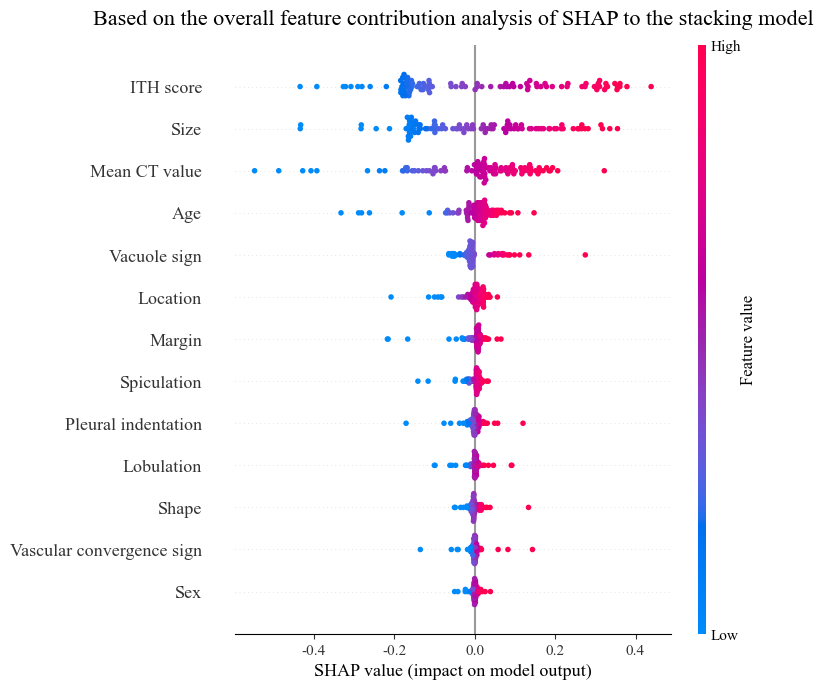

In [19]:
plt.figure()
shap.summary_plot(np.array(stacking_shap_df), stacking_shap_df, feature_names=stacking_shap_df.columns, plot_type="dot", show=False)
plt.title("Based on the overall feature contribution analysis of SHAP to the stacking model", fontsize=16, y=1.02)
plt.savefig("Based on the overall feature contribution analysis of SHAP to the stacking model.png", format='png', bbox_inches='tight', dpi=1200)
plt.show()

In [20]:
import pandas as pd
import numpy as np
import matplotlib
import shap
import sklearn
import xgboost
import lightgbm
import catboost

versions = {
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "matplotlib": matplotlib.__version__,
    "shap": shap.__version__,
    "scikit-learn": sklearn.__version__,
    "xgboost": xgboost.__version__,
    "lightgbm": lightgbm.__version__,
    "catboost": catboost.__version__
}

versions

{'pandas': '2.2.2',
 'numpy': '1.26.4',
 'matplotlib': '3.9.2',
 'shap': '0.45.1',
 'scikit-learn': '1.5.1',
 'xgboost': '2.1.1',
 'lightgbm': '4.5.0',
 'catboost': '1.2.5'}

In [21]:
X.max()

Location                       5.000000
Margin                         1.000000
Shape                          1.000000
Lobulation                     1.000000
Spiculation                    1.000000
Vascular convergence sign      1.000000
Vacuole sign                   1.000000
Pleural indentation            1.000000
Sex                            2.000000
Age                           81.000000
Size                          29.970000
Mean CT value               -223.240000
ITH score                      0.927144
dtype: float64

In [22]:
X.min()

Location                       1.00
Margin                         0.00
Shape                          0.00
Lobulation                     0.00
Spiculation                    0.00
Vascular convergence sign      0.00
Vacuole sign                   0.00
Pleural indentation            0.00
Sex                            1.00
Age                           15.00
Size                           5.00
Mean CT value               -812.07
ITH score                      0.00
dtype: float64